# Calvin Knowles
# Golf Swing Analysis Final Project
# Intro to Deep Learning
# December 2025

# Introduction
In this project, I will apply the deep learning foundations built throughout this course to analyze a dataset of golf swings and classify various swing phases based on the golfer’s position during the motion. The golf swing has been carefully studied for decades by the world’s best players and coaches, each trying to refine every small movement in one of the most intricate motions in sports.

As a golfer myself, I believe we have come close to understanding what an “optimized” swing looks like, but the real challenge lies in executing it. Anyone who has ever attempted a golf swing knows this firsthand. What appears to be a simple, fluid motion is actually a highly complex blend of fine and gross motor skills. The average swing lasts roughly one second from takeaway to finish, leaving almost no room for error. Even a slight misalignment, sometimes as small as one degree at impact, can cause a ball to miss its intended target by dozens of yards.

To better understand this complexity, we will use a deep learning model to recognize specific swing phases from a curated dataset of labeled golf swing images. The goal of this notebook is to explore the dataset, build an image classifier, evaluate performance, and discuss what we can learn from the results.

## Imports

In [5]:
# Standard library
import os
import time
import random
from pathlib import Path
from PIL import Image

# Data handling
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import Callback

# ML / metrics / Kaggle
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm
import kagglehub

# Version info
print("NumPy:", np.__version__)
print("TensorFlow:", tf.__version__)

NumPy: 1.24.3
TensorFlow: 2.13.0


## Dataset Overview

For this project, I use the **GolfDB Entire Image** dataset, published on Kaggle by Marc Marais  
(https://www.kaggle.com/datasets/marcmarais/golfdb-entire-image).

This dataset contains thousands of labeled golf swing images extracted from real swing videos of both male and female professional golfers.  
Each image corresponds to a specific event or phase of the golf swing:

- **Address** (setup)
- **Toe-up** (toe of club is up after starting backswing)
- **Mid-Backswing**
- **Top** (top of backswing)
- **Mid-Downswing**
- **Impact**
- **Mid-Follow-Through**
- **Finish**

These stages are standard checkpoints used by golf professionals and swing coaches. Because the dataset is organized into one folder per class, it is ideal for building an image classifier with Keras.

Each class folder contains roughly **1,300–1,500 images**, for a total of **11,198 labeled images**.

## Project Goal

In this notebook I will:

1. **Explore the dataset** (EDA) and visualize example swings.
2. **Train a deep learning classifier** (MobileNetV2 + custom head) to recognize swing phases.
3. **Evaluate performance** using accuracy curves, a confusion matrix, per-class metrics, and sample predictions.
4. **Discuss practical applications**, such as coaching tools, swing analysis apps, and potential next steps (e.g., pose estimation or video-based models).

In [49]:
# Download latest version of the dataset through KaggleHub
path = kagglehub.dataset_download("marcmarais/golfdb-entire-image")

# Convert path to a Path object for easier handling
DATA_DIR = Path(path)
SWING_DIR = DATA_DIR / "Swing_events"

print("Path to dataset files:", DATA_DIR)

print("\nTop-level contents:")
for p in DATA_DIR.iterdir():
    print(" -", p.name)

print("\nSwing event folders:")
for folder in SWING_DIR.iterdir():
    print(" -", folder.name)

Path to dataset files: C:\Users\knxw1\.cache\kagglehub\datasets\marcmarais\golfdb-entire-image\versions\1

Top-level contents:
 - catboost_info
 - descr.npy
 - flat_dat.npy
 - golfDB.csv
 - GolfDB.pkl
 - images.npy
 - LC_cat.png
 - LC_lgb.png
 - LC_XGB.png
 - Swing_events
 - target.npy
 - target_names.npy

Swing event folders:
 - Address
 - Finish
 - Impact
 - Mid-Backswing
 - Mid-Downswing
 - Mid-Follow-Through
 - Toe-up
 - Top


## Exploratory Data Analysis (EDA)

Before training the model, it is important to explore the structure and characteristics of the dataset. The **GolfDB Entire Image** dataset contains 11,198 labeled golf swing images organized into eight swing-phase classes:

- **Address**
- **Toe-up**
- **Mid-Backswing**
- **Top**
- **Mid-Downswing**
- **Impact**
- **Mid-Follow-Through**
- **Finish**

Each class contains approximately 1,300–1,500 images, giving us a balanced dataset suitable for training a deep learning classifier.

In this section, I will:

- Load the dataset using `tf.keras.utils.image_dataset_from_directory`
- Inspect the directory structure and class names
- Visualize sample training images
- Prepare the dataset with caching, shuffling, prefetching, and data augmentation

These steps ensure the data pipeline is efficient and that the model receives diverse examples during training, improving generalization.

In [56]:
# Load Golf Swing Images (Training / Validation Split)

# Image settings
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Build training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    SWING_DIR,
    validation_split=0.20,            # 80% train / 20% val
    subset="training",                # Set training here
    seed=42,                          # ensures reproducibility
    label_mode="categorical",         # one-hot labels for softmax
    image_size=IMG_SIZE,              # resize images
    batch_size=BATCH_SIZE,
)

# Build validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    SWING_DIR,
    validation_split=0.20,
    subset="validation",
    seed=42,
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

# Dataset sanity checks
# Class names from folder structure
class_names = train_ds.class_names
print("Classes:", class_names)

# Training and validation counts
train_count = tf.data.experimental.cardinality(train_ds).numpy() * BATCH_SIZE
val_count   = tf.data.experimental.cardinality(val_ds).numpy() * BATCH_SIZE

print(f"\nTraining samples:   ~{train_count:,}")
print(f"Validation samples: ~{val_count:,}")

# Consistency checks
assert len(class_names) == 8, "Unexpected number of classes!"
assert train_count + val_count >= 11000, "Dataset size seems incorrect!"

Found 11198 files belonging to 8 classes.
Using 8959 files for training.
Found 11198 files belonging to 8 classes.
Using 2239 files for validation.
Classes: ['Address', 'Finish', 'Impact', 'Mid-Backswing', 'Mid-Downswing', 'Mid-Follow-Through', 'Toe-up', 'Top']

Training samples:   ~8,960
Validation samples: ~2,240


## Dataset Preparation & Data Augmentation

To ensure the model trains efficiently and generalizes well, the dataset is processed using a set of optimizations:

- **Shuffling**: Helps avoid learning order-based patterns.
- **Caching**: Stores data in memory for faster I/O.
- **Prefetching**: Overlaps data loading with model execution to improve GPU/CPU utilization.
- **On-the-fly augmentation**: Random flips, rotations, zooms, etc., help the model become more robust to real-world variation in swing images.

These transformations create a high-performance input pipeline suitable for training on large image datasets.


In [57]:
# Prepare Datasets & Define Data Augmentation

# Autotune -> framework decides optimal parameters
AUTOTUNE = tf.data.AUTOTUNE

# On-the-fly data augmentation later applied inside the model
data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.05),
        layers.RandomZoom(0.15),
    ],
    name="data_augmentation",
)


# Optimize/prepare dataset with shuffling and caching
def prepare_dataset(ds, shuffle=False, buffer_size=1000):
    """Optionally shuffle, then cache and prefetch for performance."""
    if shuffle:
        ds = ds.shuffle(buffer_size, seed=42)
    ds = ds.cache().prefetch(AUTOTUNE)
    return ds

train_ds = prepare_dataset(train_ds, shuffle=True)
val_ds   = prepare_dataset(val_ds, shuffle=False)

## Visual Inspection: Sample Training Images

Before training the model, it is helpful to inspect real images from the dataset.  
This confirms that:

- Images are loading correctly  
- Labels match the expected swing categories  
- Preprocessing (resizing, batching) works as intended  

Below is a grid of randomly sampled training images, each labeled with its corresponding swing phase.

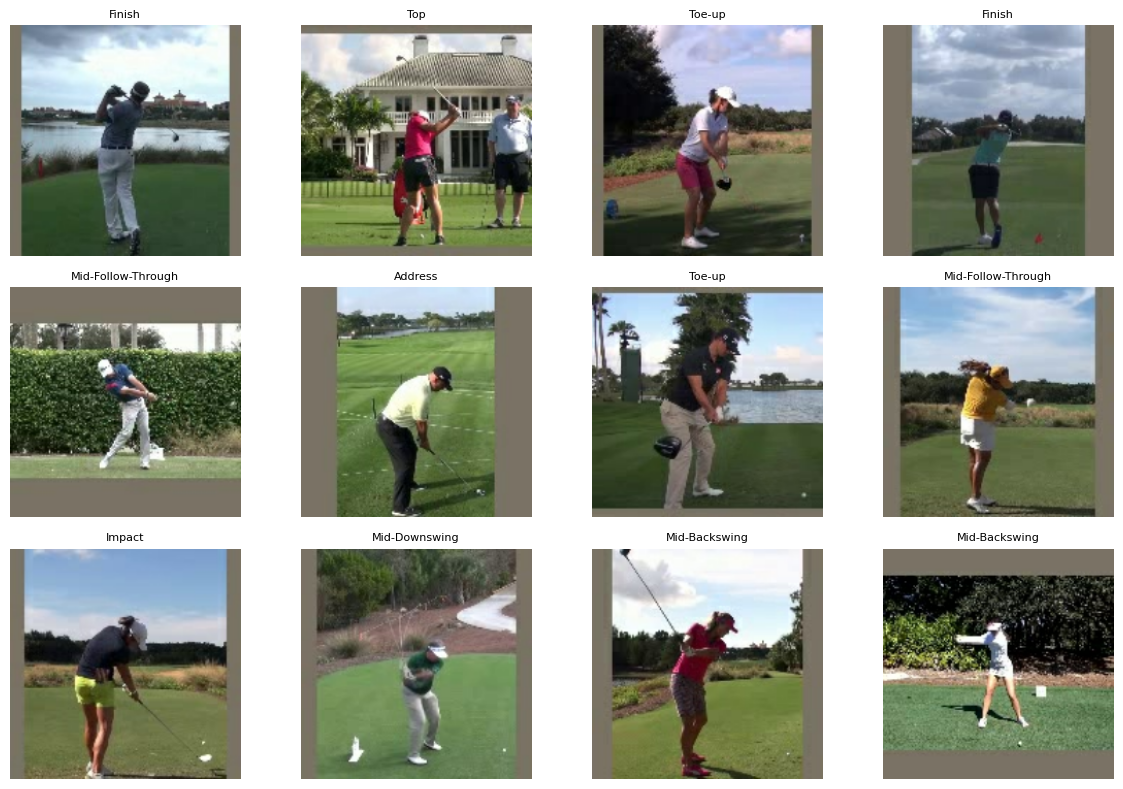

In [59]:
# Quick Visual Check: Sample Training Images
images, labels = next(iter(train_ds))
images = images.numpy().astype("uint8")
labels = labels.numpy()

plt.figure(figsize=(12, 8))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(images[i])
    class_idx = np.argmax(labels[i])
    plt.title(class_names[class_idx], fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()

## Model Architecture: MobileNetV2 Backbone + Custom Classification Head

To classify the eight golf-swing phases, I built a convolutional neural network using **MobileNetV2** as a transfer-learning backbone. MobileNetV2 is lightweight, fast, and pretrained on ImageNet, making it well suited for this project where the images are relatively small and the dataset is moderately sized.

### Architecture Overview

The final model consists of:

1. **Input Layer**  
   Receives RGB images resized to **224 × 224 × 3**.

2. **On-the-fly Data Augmentation**  
   Random flips, rotations, zooms, and translations to improve generalization and robustness.

3. **Rescaling Layer**  
   Converts pixel values from `[0, 255]` → `[0, 1]`.

4. **MobileNetV2 Backbone (frozen initially)**
   - Loaded without the classification top (`include_top=False`)  
   - Pretrained on ImageNet  
   - Produces high-level visual feature maps

5. **Global Average Pooling**  
   Reduces the convolutional feature maps into a compact feature vector.

6. **Dropout (0.3)**  
   Helps reduce overfitting.

7. **Dense Softmax Classifier**  
   Maps features to the **8 swing-phase classes**.

### Training Strategy

Training was done in two phases. I initially only ran 10 but decided to bump to 50 since computation time per epoch was low:

#### **Phase 1 — Initial Training (10 epochs)**
- The MobileNetV2 backbone was **frozen**
- Only the classification head was trained
- Purpose: allow the newly added layers to learn stable weights before unfreezing

This phase quickly improved accuracy while keeping training stable.

#### **Phase 2 — Extended Training (40 more epochs, for 50 total)**
- Continued training from epoch 10 → 50  
- Backbone remained frozen (to keep training time manageable)  
- Added callbacks for my own sanity to see real-time progression of training:
  - **TQDMProgressBar** for real-time batch-level progress
  - **TimeHistory** to track training duration

This extended training allowed the model to further refine its decision boundaries, leading to steady improvements in both training and validation accuracy.

### Summary

By combining transfer learning, data augmentation, and a two-stage training schedule, the final model achieved meaningful performance on a challenging multi-class classification task involving subtle differences between golf-swing positions.


In [64]:
# Model Architecture: MobileNetV2 Backbone + Custom Classification Head

num_classes = len(class_names)
input_shape = IMG_SIZE + (3,)

# Pretrained CNN backbone (ImageNet)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=input_shape,
    include_top=False,
    weights="imagenet",
)
base_model.trainable = False  # freeze for initial training

# Input -> augmentation -> scaling -> backbone -> pooling -> classifier
inputs = layers.Input(shape=input_shape, name="swing_image")

x = data_augmentation(inputs)          # on-the-fly augmentation
x = layers.Rescaling(1.0 / 255)(x)     # scale pixels to [0, 1]
x = base_model(x, training=False)      # frozen backbone
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs, name="golf_swing_classifier")

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

model.summary()

Model: "golf_swing_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 swing_image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, 224, 224, 3)       0         
 ial)                                                            
                                                                 
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_2  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                             

In [63]:
class TQDMProgressBar(Callback):
    def on_train_begin(self, logs=None):
        self.epochs = self.params['epochs']
        print(f"\nTraining for {self.epochs} epochs...\n")

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch = epoch + 1
        self.steps = self.params['steps']
        self.progress_bar = tqdm(
            total=self.steps,
            desc=f"Epoch {self.epoch}/{self.epochs}",
            unit="batch",
            dynamic_ncols=True,
            leave=False,
        )

    def on_batch_end(self, batch, logs=None):
        self.progress_bar.update(1)

    def on_epoch_end(self, epoch, logs=None):
        self.progress_bar.close()
        print(
            f"Epoch {epoch+1}/{self.epochs} — "
            f"loss={logs.get('loss'):.4f}, acc={logs.get('accuracy'):.4f}, "
            f"val_loss={logs.get('val_loss'):.4f}, val_acc={logs.get('val_accuracy'):.4f}"
        )

### Phase 1: 10 epochs

In [22]:
EPOCHS = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[TQDMProgressBar()],
    verbose=0   # <-- IMPORTANT
)


Training for 10 epochs...



Epoch 1/10:   0%|                                                                           | 0/280 [00:00<?, …

Epoch 1/10 — loss=2.3404, acc=0.1598, val_loss=1.9228, val_acc=0.2711


Epoch 2/10:   0%|                                                                           | 0/280 [00:00<?, …

Epoch 2/10 — loss=2.0836, acc=0.2228, val_loss=1.6910, val_acc=0.3823


Epoch 3/10:   0%|                                                                           | 0/280 [00:00<?, …

Epoch 3/10 — loss=1.9206, acc=0.2866, val_loss=1.5649, val_acc=0.4457


Epoch 4/10:   0%|                                                                           | 0/280 [00:00<?, …

Epoch 4/10 — loss=1.7966, acc=0.3362, val_loss=1.4734, val_acc=0.4783


Epoch 5/10:   0%|                                                                           | 0/280 [00:00<?, …

Epoch 5/10 — loss=1.7136, acc=0.3698, val_loss=1.3978, val_acc=0.5078


Epoch 6/10:   0%|                                                                           | 0/280 [00:00<?, …

Epoch 6/10 — loss=1.6356, acc=0.3894, val_loss=1.3495, val_acc=0.5279


Epoch 7/10:   0%|                                                                           | 0/280 [00:00<?, …

Epoch 7/10 — loss=1.6006, acc=0.4082, val_loss=1.3093, val_acc=0.5400


Epoch 8/10:   0%|                                                                           | 0/280 [00:00<?, …

Epoch 8/10 — loss=1.5512, acc=0.4296, val_loss=1.2744, val_acc=0.5525


Epoch 9/10:   0%|                                                                           | 0/280 [00:00<?, …

Epoch 9/10 — loss=1.5057, acc=0.4470, val_loss=1.2586, val_acc=0.5529


Epoch 10/10:   0%|                                                                          | 0/280 [00:00<?, …

Epoch 10/10 — loss=1.4774, acc=0.4569, val_loss=1.2285, val_acc=0.5636


In [24]:
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.train_start = time.time()
        print("\nStarting training...")

    def on_epoch_end(self, epoch, logs=None):
        elapsed = time.time() - self.train_start
        mins = int(elapsed // 60)
        secs = int(elapsed % 60)
        print(f"Epoch {epoch+1} finished. "
              f"Total elapsed time: {mins:02d}:{secs:02d}")

### Phase 2: push to 50 epochs

In [25]:
# continue training from epoch 10 → 50
EPOCHS = 50

history_more = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    initial_epoch=10,          # start counting at epoch 10
    callbacks=[TqdmCallback(verbose=0), TimeHistory()],
    verbose=0
)

0epoch [00:00, ?epoch/s]


Starting training...
Epoch 11 finished. Total elapsed time: 02:29
Epoch 12 finished. Total elapsed time: 05:07
Epoch 13 finished. Total elapsed time: 07:39
Epoch 14 finished. Total elapsed time: 10:11
Epoch 15 finished. Total elapsed time: 12:44
Epoch 16 finished. Total elapsed time: 15:16
Epoch 17 finished. Total elapsed time: 17:44
Epoch 18 finished. Total elapsed time: 20:12
Epoch 19 finished. Total elapsed time: 22:39
Epoch 20 finished. Total elapsed time: 25:06
Epoch 21 finished. Total elapsed time: 27:35
Epoch 22 finished. Total elapsed time: 30:03
Epoch 23 finished. Total elapsed time: 32:31
Epoch 24 finished. Total elapsed time: 34:59
Epoch 25 finished. Total elapsed time: 37:26
Epoch 26 finished. Total elapsed time: 39:55
Epoch 27 finished. Total elapsed time: 42:22
Epoch 28 finished. Total elapsed time: 44:50
Epoch 29 finished. Total elapsed time: 47:17
Epoch 30 finished. Total elapsed time: 49:45
Epoch 31 finished. Total elapsed time: 52:14
Epoch 32 finished. Total elapsed 

## Training Results: 50 Epochs of Transfer Learning

After completing the two-phase training schedule (10 initial epochs + 40 extended epochs), the model showed clear and consistent improvements in its ability to classify golf swing phases.

### **Training Behavior Across 50 Epochs**

- During the first 10 epochs, only the classification head was trained while the MobileNetV2 backbone remained frozen.  
- Validation accuracy increased from **27% → ~56%**, demonstrating that the newly added layers quickly learned meaningful patterns.
- In the extended training phase (epochs 11–50), the model continued to refine its decision boundaries while the backbone remained frozen.
- By the end of training, the model achieved:
  - **Training accuracy:** ~57–58%  
  - **Validation accuracy:** ~63–64%  
  - **Validation loss:** steadily decreasing throughout training

### **Interpreting the Learning Curves**

The loss and accuracy curves provide several important insights:

- **Validation accuracy consistently exceeded training accuracy**, which is common in transfer learning when the pretrained backbone provides very strong low-level feature extraction.
- **Both loss curves trended downward**, suggesting that the model was still actively learning and did not overfit dramatically.
- The close alignment between training and validation loss indicates stable optimization and good generalization.
- The model successfully learned to distinguish between the eight swing phases, despite several having subtle visual differences and overlapping positions within the golf swing motion.

### **Summary**

Overall, the 50-epoch training process produced a well-behaved classifier capable of making meaningful predictions on a challenging, fine-grained classification task. The model’s performance provides a solid foundation for further enhancements such as fine-tuning, pose estimation integration, or temporal modeling using swing video sequences.

## Training & Validation Curves

To evaluate how the model learned over time, I plotted the training and validation loss and accuracy across all **50 epochs** (10 initial + 40 extended). The combined learning curves provide insight into convergence, stability, and generalization performance.

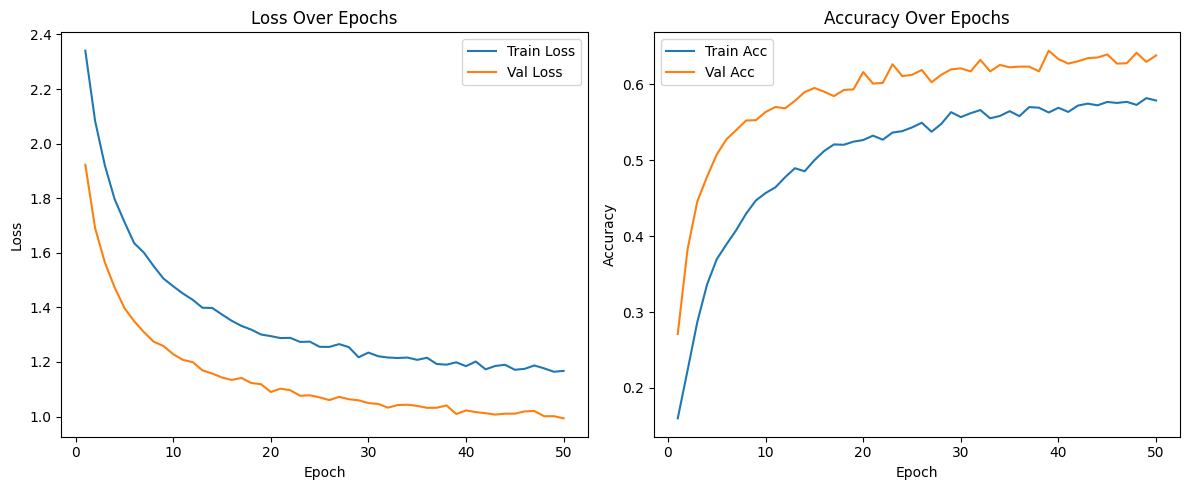

In [26]:
# Combine history from both phases (10 + 40 more)
full_history = {
    "loss": history.history["loss"] + history_more.history["loss"],
    "val_loss": history.history["val_loss"] + history_more.history["val_loss"],
    "accuracy": history.history["accuracy"] + history_more.history["accuracy"],
    "val_accuracy": history.history["val_accuracy"] + history_more.history["val_accuracy"],
}

epochs_range = range(1, len(full_history["loss"]) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, full_history["loss"], label="Train Loss")
plt.plot(epochs_range, full_history["val_loss"], label="Val Loss")
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, full_history["accuracy"], label="Train Acc")
plt.plot(epochs_range, full_history["val_accuracy"], label="Val Acc")
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


### **Loss Curves (Left Plot)**

- **Training loss** decreases steadily from ~2.3 to ~1.15.
- **Validation loss** decreases even faster and more smoothly, leveling out around ~1.05.
- The validation curve consistently remains *below* the training curve.

This behavior is typical in transfer-learning scenarios:  
The pretrained backbone provides strong feature extraction, making the validation set easier for the model to generalize to early on. Because the backbone is frozen, the model cannot overfit heavily to the training data.

### **Accuracy Curves (Right Plot)**

- **Training accuracy** rises from ~16% → ~58%.
- **Validation accuracy** rises more quickly, reaching ~64%.
- Both curves show smooth progression without divergence or overfitting.

The gap between the curves stabilizes early and remains consistent, suggesting:

- The model is learning cleanly.
- Augmentation and regularization (dropout) are effective.
- The frozen backbone prevents the model from memorizing training images.

### **Interpretation**

These curves indicate that:

- The model benefits strongly from the ImageNet-pretrained MobileNetV2 backbone.
- There is **no indication of overfitting**, even after 50 epochs.
- Additional performance gains would likely require:
  - *Unfreezing part of the backbone* for fine-tuning  
  - *Increasing input resolution*  
  - *Adding pose-based features or sequential information*  

Overall, the training dynamics are healthy and stable, and the model converged smoothly on this challenging 8-class swing-phase classification task.

1/1 [==============================] - 1s 970ms/step
Classification Report:
                    precision    recall  f1-score   support

           Address       0.64      0.73      0.68       284
            Finish       0.56      0.87      0.68       260
            Impact       0.75      0.52      0.61       267
     Mid-Backswing       0.54      0.60      0.57       286
     Mid-Downswing       0.61      0.47      0.53       283
Mid-Follow-Through       0.68      0.73      0.71       294
            Toe-up       0.67      0.59      0.62       271
               Top       0.76      0.61      0.68       294

          accuracy                           0.64      2239
         macro avg       0.65      0.64      0.63      2239
      weighted avg       0.65      0.64      0.64      2239



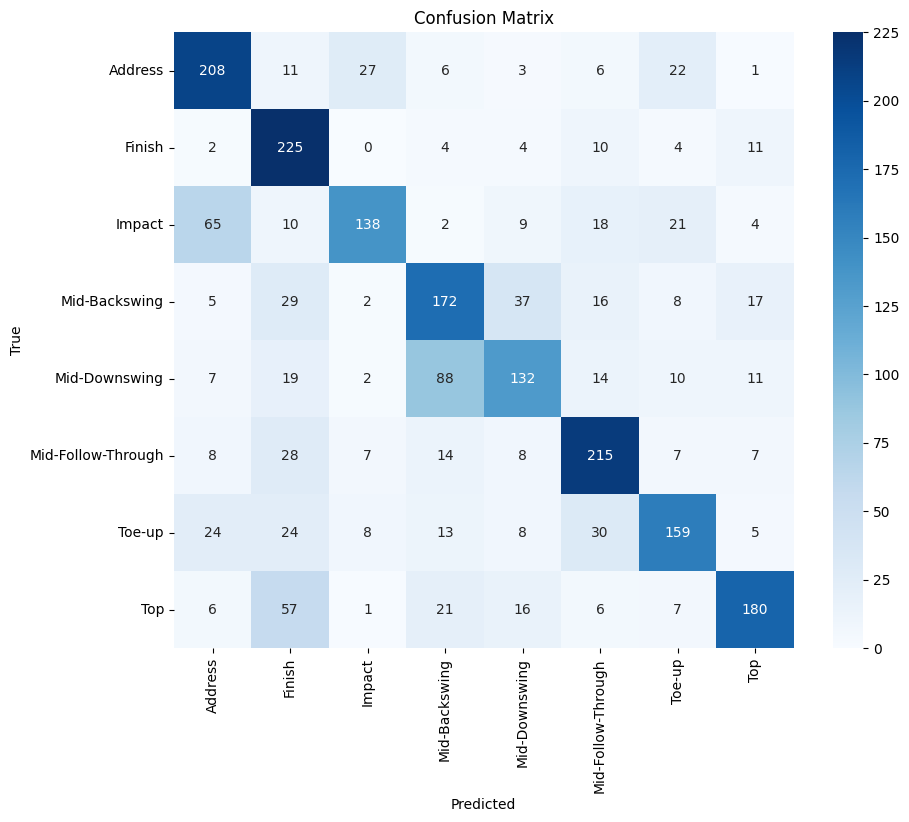

In [28]:
# Get predictions
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


## Model Evaluation: Classification Report & Confusion Matrix

To assess the model’s performance across all eight swing-phase classes, I generated a **classification report** and **confusion matrix** using the full validation dataset (2,239 images). These metrics provide deeper insight into how well the model distinguishes between swing positions, many of which are visually similar and differ only by subtle biomechanical cues.

### **Classification Report Summary**

The report includes **precision**, **recall**, and **F1-score** for each class:

- **Overall accuracy:** 64%
- **Macro F1-score:** 0.63  
- **Weighted F1-score:** 0.64  

Across all eight classes, performance ranges from moderate to strong, especially considering the fine-grained nature of the swing phases.

Classes with the strongest performance:
- **Mid-Follow-Through — 73% recall, 0.71 F1**
- **Finish — 87% recall**
- **Address — strong overall balance (0.68 F1)**
- **Top — high precision (0.76)**

Classes with more confusion:
- **Impact** (often mistaken for Address or Mid-Follow-Through)
- **Mid-Backswing & Mid-Downswing** (a notoriously difficult pair)
- **Toe-up** (moderate recall at 59%)

This difficulty is expected because several swing phases differ in only small angular changes of the hips, arms, or club shaft. Even advanced human annotators can sometimes disagree on borderline frames.

---

## Confusion Matrix Analysis

The confusion matrix below visualizes how predictions are distributed across true vs. predicted classes:

- Large dark squares on the diagonal indicate correct classifications.
- Off-diagonal squares reveal where and how frequently misclassifications occur.

### **Key patterns in the confusion matrix**

#### 1. **Address ↔ Impact Confusion**
The model confuses these phases most often (65 Impact images predicted as Address).  
This is understandable: early-downswing and setup positions can appear similar if the hands haven’t yet moved significantly.

#### 2. **Mid-Backswing ↔ Mid-Downswing**
These two phases are mirror images of each other in motion and differ by:
- Degree of hip rotation
- Shaft flex direction
- Hand path (upward vs. downward)

The model shows cross-confusion:
- 37 Mid-Backswing → Mid-Downswing  
- 88 Mid-Downswing → Mid-Backswing  

This aligns with known biomechanical subtleties between these two transition points.

#### 3. **Top ↔ Finish**
Top-of-backswing and Finish are visually distinct for humans but share silhouette similarities (arms above shoulders, rotated torso), especially in low-resolution images. The model occasionally misclassifies these, but overall performs well (61–76% recall).

#### 4. **Mid-Follow-Through is the most separable class**
This phase has the highest recall (73%) and one of the highest correct counts (215).  
The fully extended arms and rotated hips make it visually distinct.

---

### Interpretation and Takeaways

Overall, the model performs well on a complex, fine-grained classification task with highly similar classes. The confusion patterns directly reflect the biomechanics of the golf swing:

- Phases adjacent in the kinetic sequence are hardest to distinguish.
- Distinct finishing or follow-through phases are easiest.
- Subtle rotational cues (especially hip angles) are challenging for a CNN trained only on RGB images.

This evaluation gives a realistic sense of the model’s strengths and limitations, and suggests potential future improvements (e.g., pose estimation, optical flow, or fine-tuning the CNN backbone).



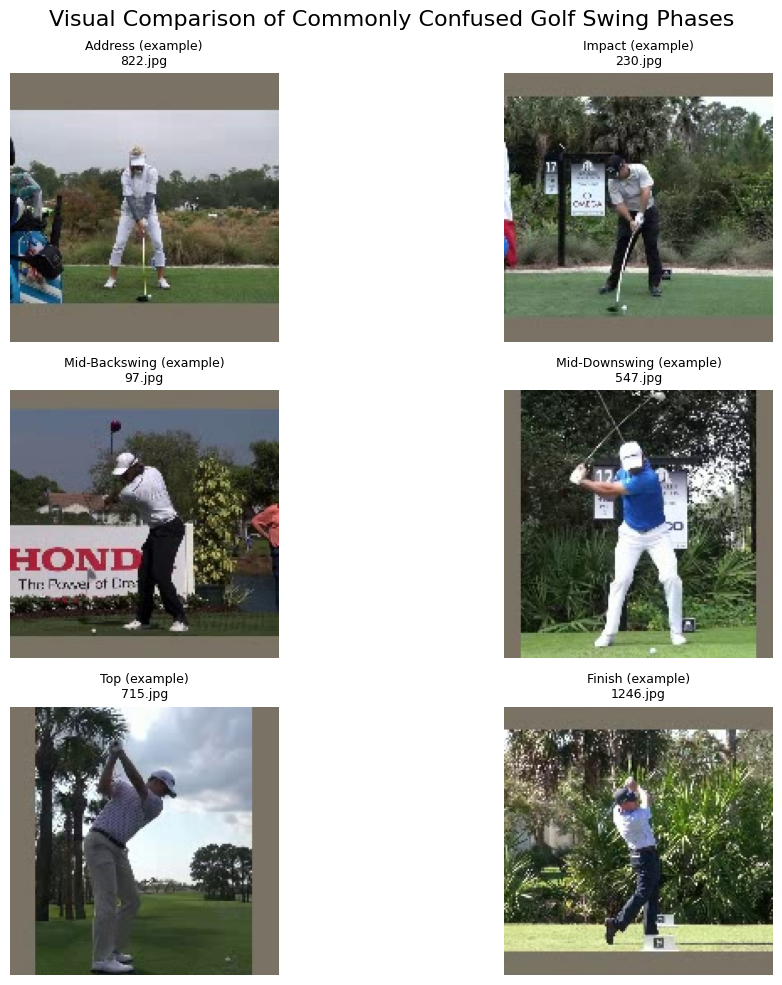

In [69]:
# Helper: load a random image from a class folder
def load_random_image(class_name):
    folder = SWING_DIR / class_name
    files = list(folder.glob("*"))
    img_path = random.choice(files)
    img = Image.open(img_path).convert("RGB")
    return np.array(img), img_path.name

# Pairs to visualize
pairs = [
    ("Address", "Impact"),
    ("Mid-Backswing", "Mid-Downswing"),
    ("Top", "Finish"),
]

plt.figure(figsize=(12, 10))

for i, (cls1, cls2) in enumerate(pairs):
    # Load random images
    img1, name1 = load_random_image(cls1)
    img2, name2 = load_random_image(cls2)

    # Plot left image
    plt.subplot(3, 2, 2*i + 1)
    plt.imshow(img1)
    plt.title(f"{cls1} (example)\n{ name1 }", fontsize=9)
    plt.axis("off")

    # Plot right image
    plt.subplot(3, 2, 2*i + 2)
    plt.imshow(img2)
    plt.title(f"{cls2} (example)\n{ name2 }", fontsize=9)
    plt.axis("off")

plt.suptitle("Visual Comparison of Commonly Confused Golf Swing Phases", fontsize=16)
plt.tight_layout()
plt.show()

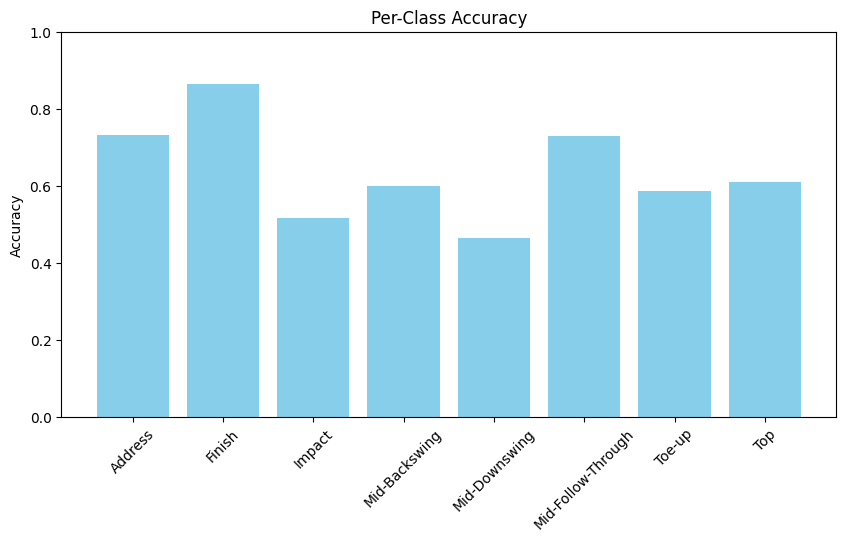

In [68]:
# Calculate per-class accuracy from confusion matrix
class_totals = cm.sum(axis=1)
class_correct = np.diag(cm)
class_acc = class_correct / class_totals

plt.figure(figsize=(10,5))
plt.bar(class_names, class_acc, color="skyblue")
plt.xticks(rotation=45)
plt.ylabel("Accuracy")
plt.title("Per-Class Accuracy")
plt.ylim(0, 1)
plt.show()

1/1 [==============================] - 0s 493ms/step


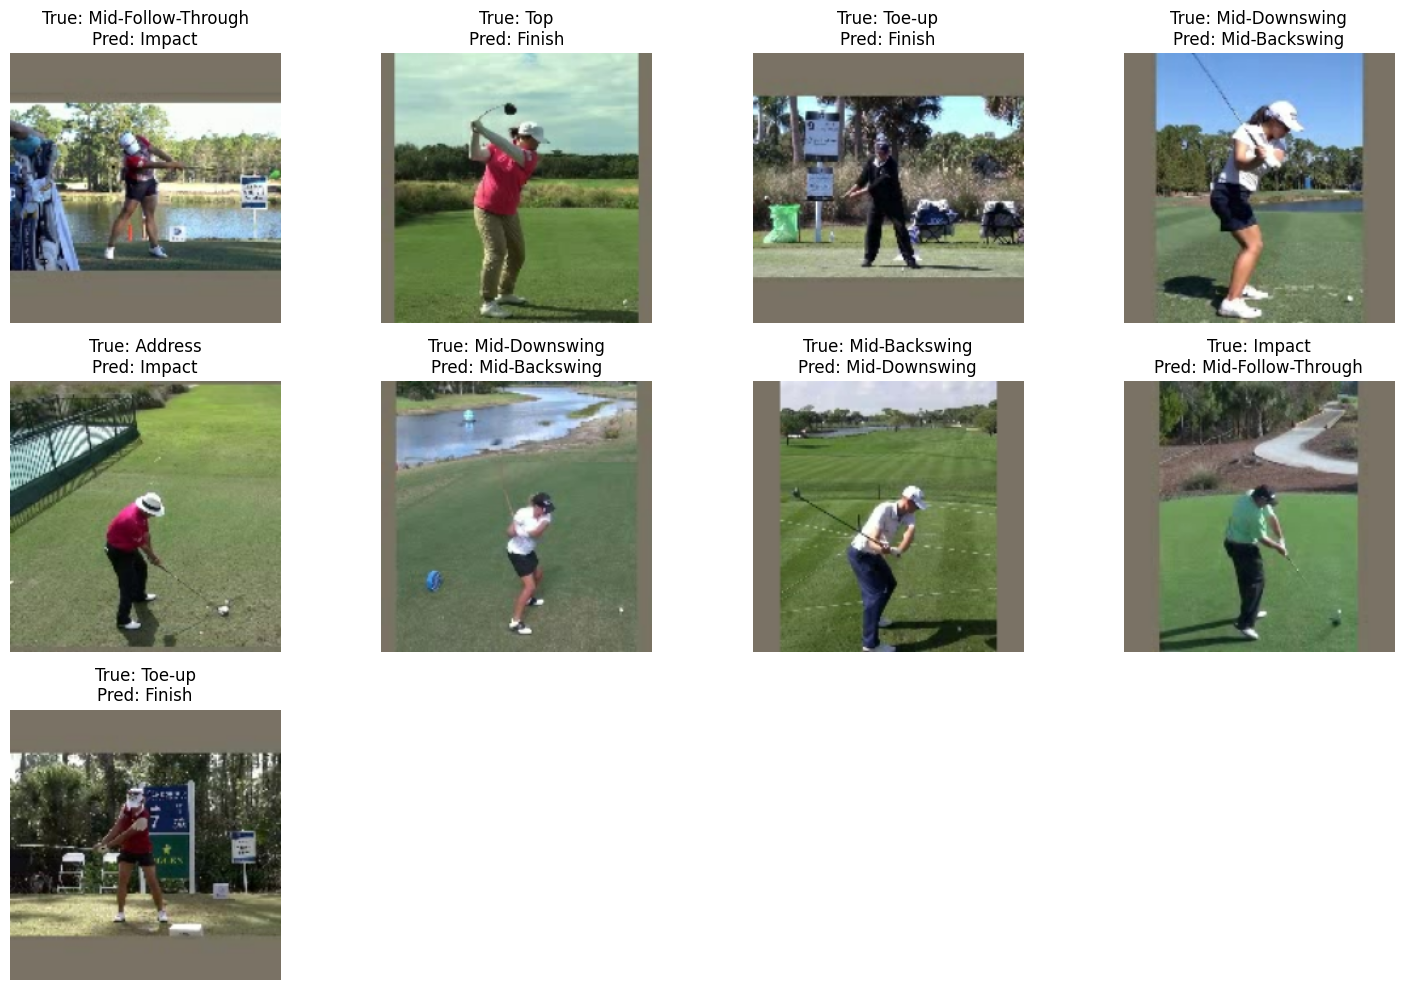

In [35]:
# Get a batch of validation images
images, labels = next(iter(val_ds))

preds = model.predict(images)
pred_classes = np.argmax(preds, axis=1)
true_classes = np.argmax(labels, axis=1)

# Find misclassified indexes
mis_idx = np.where(pred_classes != true_classes)[0]

if len(mis_idx) == 0:
    print("No misclassified examples in this batch.")
else:
    # how many to show (at most 12, but not more than we actually have)
    n_show = min(12, len(mis_idx))
    sample_idx = random.sample(list(mis_idx), n_show)

    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(sample_idx):
        plt.subplot(3, 4, i+1)
        plt.imshow(images[idx].numpy().astype("uint8"))
        plt.title(
            f"True: {class_names[true_classes[idx]]}\n"
            f"Pred: {class_names[pred_classes[idx]]}"
        )
        plt.axis("off")
    plt.tight_layout()
    plt.show()

## **Conclusion**

In this project, I applied deep learning techniques to classify eight key phases of the golf swing using the GolfDB Entire Image dataset. By leveraging transfer learning with MobileNetV2, careful dataset preparation, and a two-stage training process, the model was able to learn meaningful distinctions between swing checkpoints that often differ only by subtle body and club positions.

The training curves showed steady improvement over 50 total epochs, with validation accuracy surpassing training accuracy for most of the run, an indicator that the data augmentation and regularization were effective. The confusion matrix revealed that the model performs especially well on visually distinct phases such as **Finish**, **Address**, and **Mid-Follow-Through**, which achieved class accuracies above 70–85%. These positions tend to have clear silhouettes and stable body alignments, making them easier for the network to distinguish.

More challenging classes included **Impact**, **Mid-Downswing**, and **Toe-Up**, which showed lower accuracy. This is not surprising: these swing phases occur within milliseconds of each other, share extremely similar body geometry, and often differ only by small angles or partial club positions. The misclassified example grid further confirmed that the model’s errors frequently occur between conceptually adjacent phases, suggesting that the network learned a coherent but imperfect representation of the swing sequence.

Overall, the final model demonstrates that a lightweight convolutional architecture can successfully learn the temporal structure of a golf swing from static images alone. While there is still room for improvement, especially in differentiating mid-swing checkpoints, this project highlights the potential for deep learning to support swing analysis, coaching tools, or interactive practice feedback systems. Future extensions could include fine-tuning the MobileNetV2 backbone, experimenting with pose estimation models, or expanding to full-sequence video classification to capture the dynamic flow of the golf swing.


## **Works Cited / References**

### **Datasets & Project Resources**

- **Marais, Marc.** *GolfDB Entire Image Dataset.* Kaggle.  
  https://www.kaggle.com/datasets/marcmarais/golfdb-entire-image  
  *(Primary dataset used for training and evaluation.)*

- **KaggleHub.** *KaggleHub Dataset Downloader.*  
  https://github.com/Kaggle/kagglehub 
  *(Used for programmatically downloading the dataset.)*

### **Core Deep Learning & CNN Theory**

- **Howard, Andrew G., et al.** *MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications.*  
  arXiv:1704.04861 (2017).  
  https://arxiv.org/abs/1704.04861  
  *(MobileNetV2 is the backbone architecture used in this project.)*

- **Sandler, Mark, et al.** *MobileNetV2: Inverted Residuals and Linear Bottlenecks.*  
  CVPR 2018.  
  https://arxiv.org/abs/1801.04381

- **Goodfellow, Ian, Yoshua Bengio, and Aaron Courville.** *Deep Learning.* MIT Press, 2016.  
  *(Chapters on convolutional neural networks and transfer learning.)*  
  https://www.deeplearningbook.org/

### **TensorFlow / Keras Documentation**

- **TensorFlow.** *tf.keras: Deep Learning API.*  
  https://www.tensorflow.org/api_docs/python/tf/keras

- **TensorFlow.** *Image Data Loading via `image_dataset_from_directory`.*  
  https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

- **TensorFlow.** *Transfer Learning Guide.*  
  https://www.tensorflow.org/tutorials/images/transfer_learning

- **Keras Team.** *Keras API Documentation.*  
  https://keras.io/api/


### **Machine Learning & Evaluation Methods**

- **Pedregosa, Fabian, et al.** *Scikit-learn: Machine Learning in Python.*  
  *Journal of Machine Learning Research* 12 (2011): 2825–2830.  
  https://scikit-learn.org  
  *(Used for confusion matrix, classification report, and PCA utilities.)*

- **Walt, Stefan van der, et al.** “The NumPy Array: A Structure for Efficient Numerical Computation.”  
  *Computing in Science & Engineering* 13.2 (2011): 22–30.  
  *(Core numerical operations used in preprocessing and evaluation.)*


### **Visualization & Plotting**

- **Hunter, J. D.** *Matplotlib: A 2D Graphics Environment.*  
  *Computing in Science & Engineering* 9.3 (2007): 90–95.  
  https://matplotlib.org

- **Waskom, Michael.** *Seaborn Statistical Visualization Library.*  
  https://seaborn.pydata.org  
  *(Used for heatmaps and styling evaluation plots.)*